In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

prices = pd.read_excel('data/prices.xlsx', index_col=0)
precipitations_mm = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm')
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals')
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals')
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count')

# Exploring data

## Exploring price data

To get the first feel of the data, I will plot the Premiers Crus from Medoc, from the 1855 ranking.

,Chateau,Vintage,Price
0,Château Lafite Rothschild Pauillac,1950,671.0
1,Château Lafite Rothschild Pauillac,1951,1133.0
2,Château Lafite Rothschild Pauillac,1952,284.0
3,Château Lafite Rothschild Pauillac,1953,2666.0
4,Château Lafite Rothschild Pauillac,1954,574.0


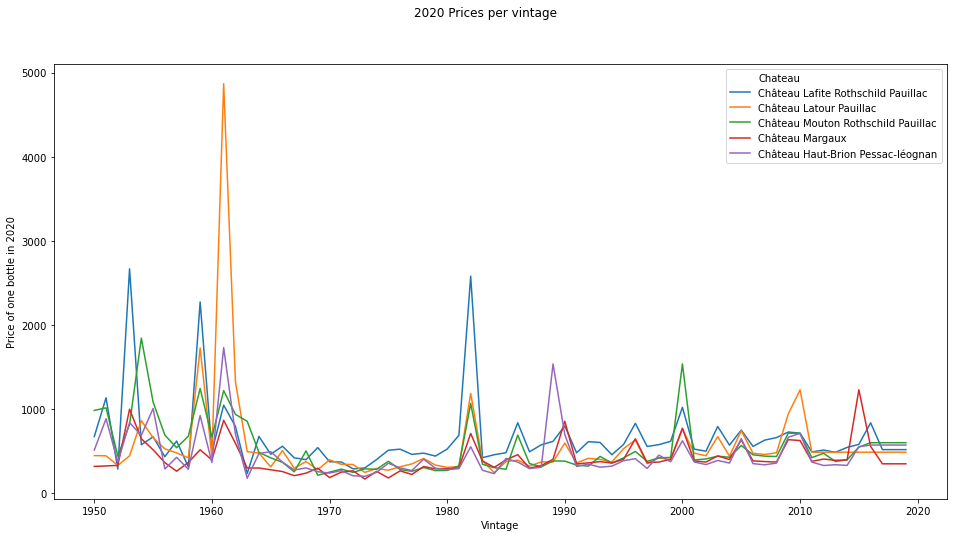

In [9]:
premiers = prices[(prices['Category'].isin(['Premier cru 1855']))].drop('Category', axis=1).transpose().fillna(method='ffill')
premiers = premiers.replace(-100, np.NaN)
premiers = premiers.reset_index()
premiers = premiers.melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]

premiers['Vintage'] = premiers['Vintage'].astype(int)

display(premiers.head())

plt.figure(figsize=(16,8))
plot = sns.lineplot(data=premiers, x='Vintage', y='Price', hue='Chateau')
plt.ylabel('Price of one bottle in 2020')
plt.xlabel('Vintage')
plt.suptitle('2020 Prices per vintage')
plt.show()

Bear in mind that we have on the x-axis, not years on which prices were measured for the same bottle, but the different vintage for which we recorded the 2020 prices. The prices explode on the good years, which makes the rest of their variation harder to see. Let us approach this with a different function.

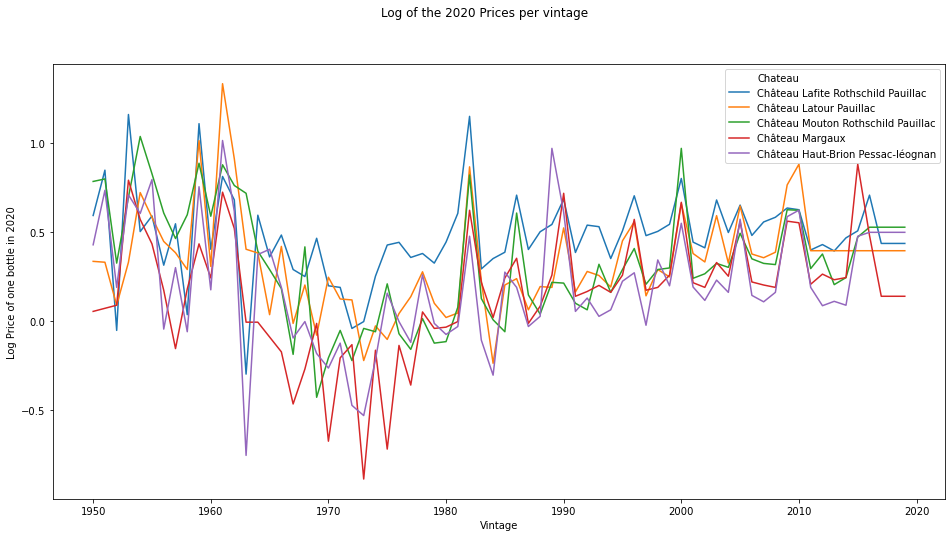

In [34]:
#Creating a strange price function will help distinguish trends
premiers['Log Price'] = np.log(np.log(premiers['Price'])- 4.7)

plt.figure(figsize=(16,8))
plot = sns.lineplot(data=premiers, x='Vintage', y='Log Price', hue='Chateau')
plt.ylabel('Log Price of one bottle in 2020')
plt.xlabel('Vintage')
plt.suptitle('Log of the 2020 Prices per vintage')
plt.show()

The variations appear more clearly here. It seems that wine prices today decline for bottles from the vintage 1950 to the 1970 vintage, which is coherent with the fact that aging wine gains a collectible value. But after that, the prices rise, which could be due to improving winemaking techniques, a positive trend in weather, or a wine price bubble. The different wines from the sample behave quit consistently.

## Creating our wine sample

So far, I've considered only the 1855 Premiers crus (First Growth). But I want to include other wines to have a more consistent sample. Where to get them? I have a sample of Saint-Emilion Premiers Crus and 1855 seconds crus.
I will rank them based on their price, for vintages later than 1980.

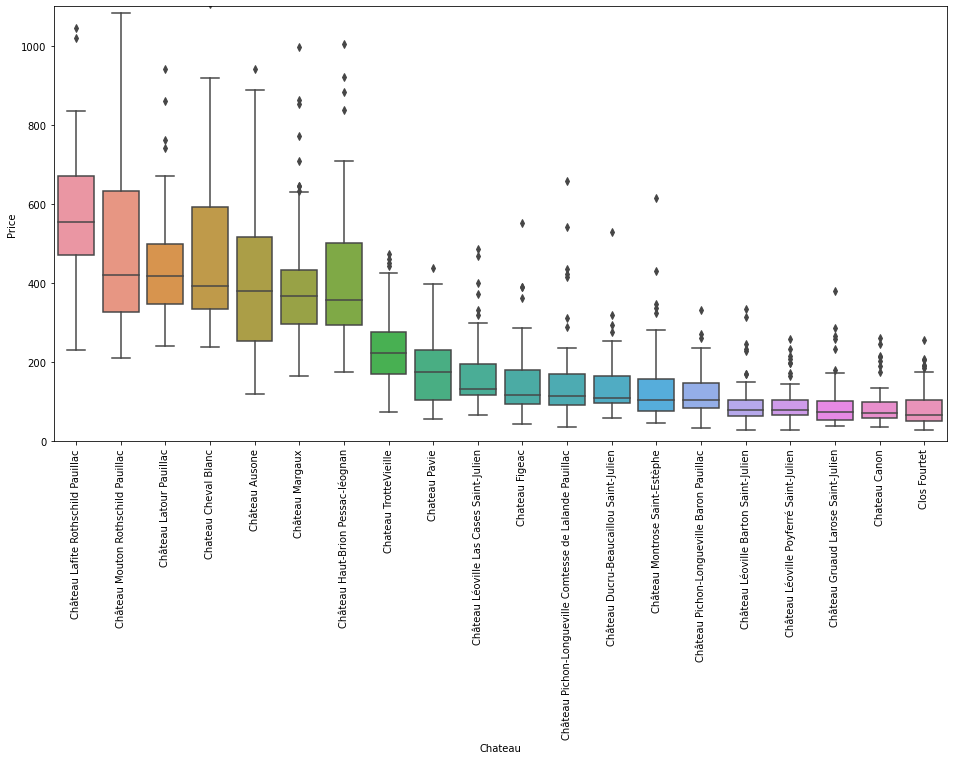

In [4]:
df = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df = df.replace(-100, np.NaN)


ranking = df.groupby('Chateau')['Price'].median().sort_values(ascending=False)
top_wines = ranking.index.to_list()[:20]

plt.figure(figsize=(16, 8))
sns.boxplot(data=df[(df['Chateau'].isin(top_wines))], x='Chateau', y='Price', order = top_wines)
plt.xticks(rotation=90)
plt.ylim(0,1100)
plt.show()

A gap clearly appears between Chateau Haut-Brion and Chateau Trottevieille. I will thus draw here the line of separation. Two wines from Saint-Emilion have now joined the first sample.

In [5]:
top_wines = top_wines[:7]

,Chateau,Vintage,Price
0,Château Lafite Rothschild Pauillac,1950,671.0
1,Château Lafite Rothschild Pauillac,1951,1133.0
2,Château Lafite Rothschild Pauillac,1952,284.0
3,Château Lafite Rothschild Pauillac,1953,2666.0
4,Château Lafite Rothschild Pauillac,1954,574.0


C:\Users\Rico\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Rico\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


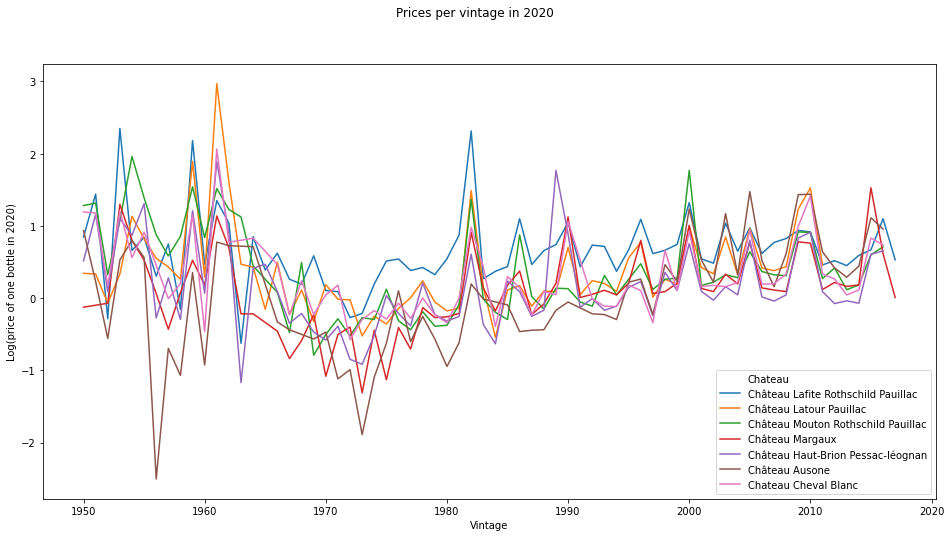

In [6]:
premiers = df[df['Chateau'].isin(top_wines)]
display(premiers.head())
premiers.loc[:,'Log Price'] = np.log(premiers['Price']-100)-5.5
premiers.loc[:,'Vintage'] = premiers['Vintage'].astype(int)

plt.figure(figsize=(16,8))
sns.lineplot(data=premiers, x='Vintage', y='Log Price', hue='Chateau')
plt.ylabel('Log(price of one bottle in 2020)')
plt.xlabel('Vintage')
plt.suptitle('Prices per vintage in 2020')
plt.savefig('data/prices_per_vintage.png')
plt.show()

The seven wines of our sample have consistent variations.

In [7]:
average = premiers.groupby('Vintage')['Log Price'].mean()

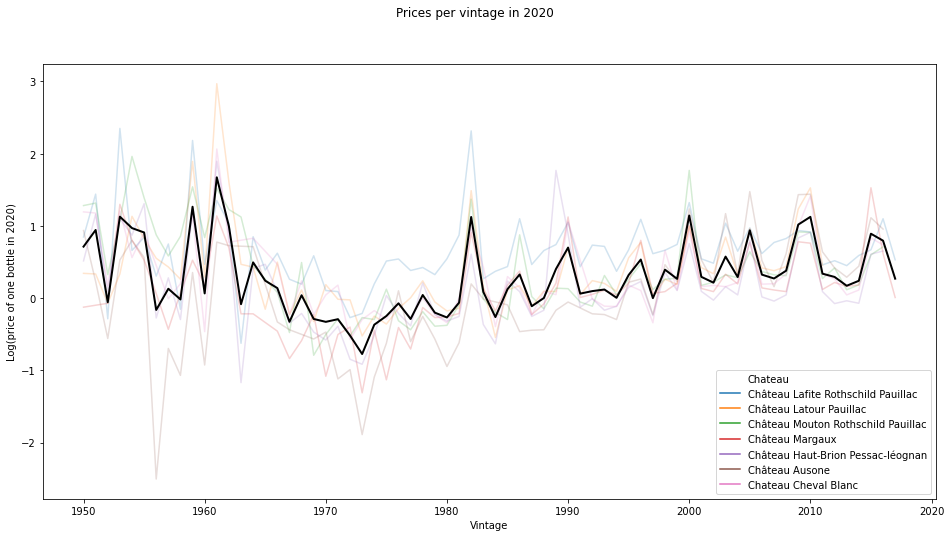

In [8]:
plt.figure(figsize=(16,8))
sns.lineplot(data=premiers, x='Vintage', y='Log Price', hue='Chateau', alpha=0.2)
sns.lineplot(data=average, linewidth=2.0, color='black')

plt.ylabel('Log(price of one bottle in 2020)')
plt.xlabel('Vintage')
plt.suptitle('Prices per vintage in 2020')
plt.show()

## Filtering input

Now, the goal here is to even out the global trend by filtering the price range into a trend and a residual component.

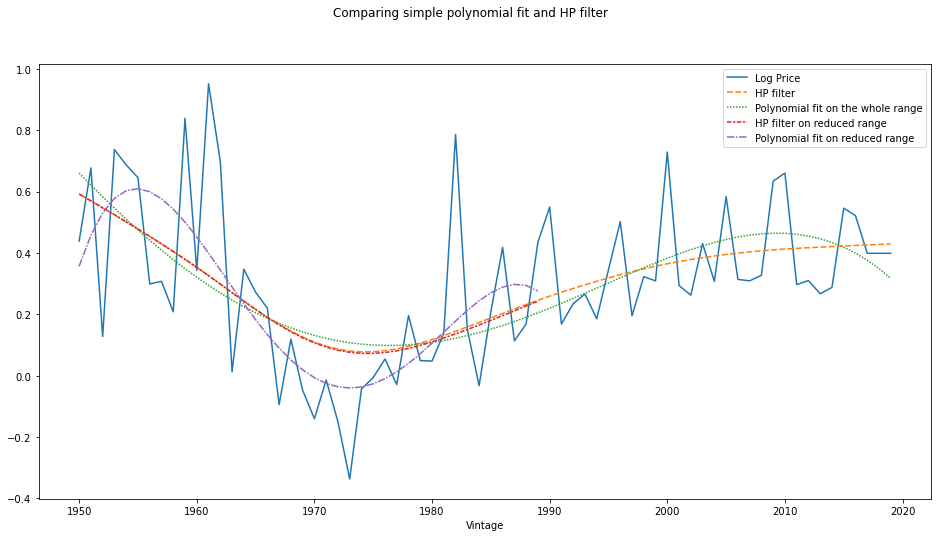

C:\Users\Rico\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


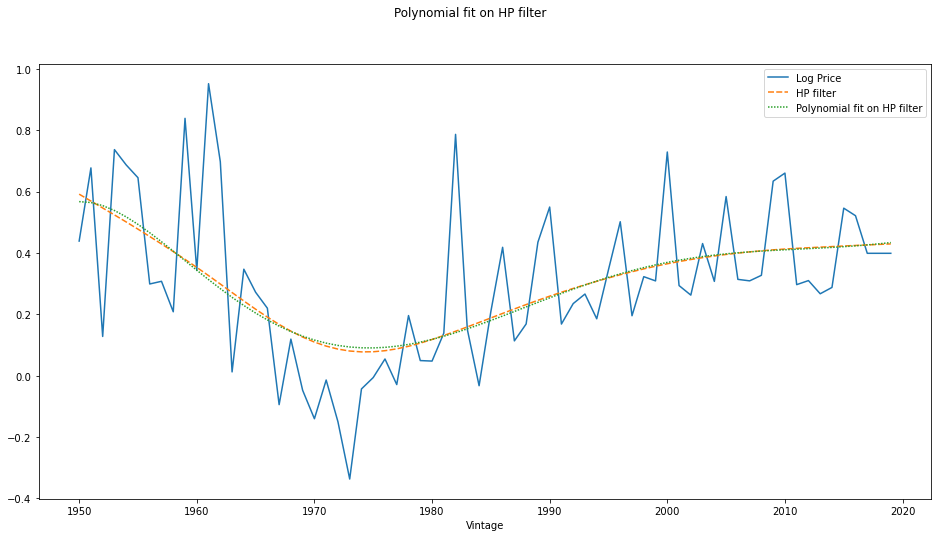

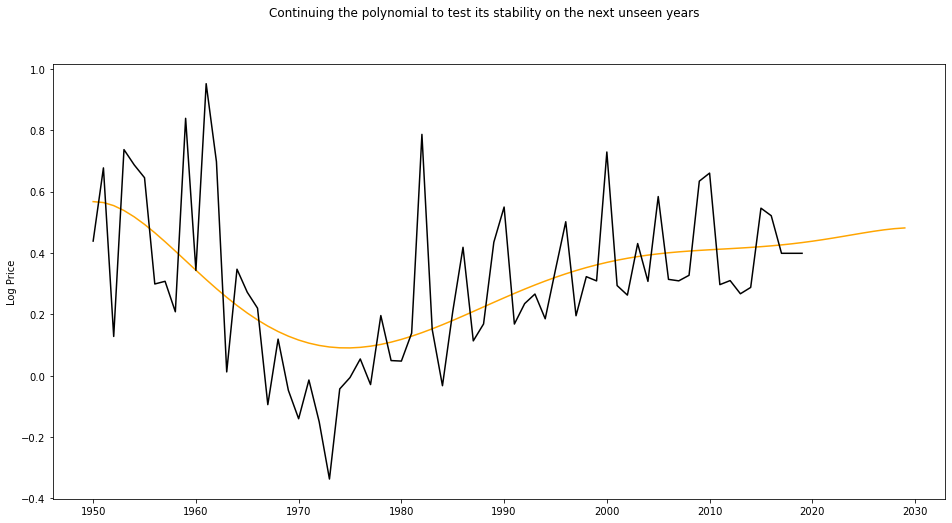

In [124]:
import statsmodels.api as sm

average = premiers.groupby('Vintage')['Log Price'].mean().dropna(axis=0).to_frame()

# Try a Hodrick Prescott filter
average['HP filter'] = sm.tsa.filters.hpfilter(average['Log Price'], lamb=2000)[1]

fit = np.polyfit(average.index,average['Log Price'], 4)
poly = np.poly1d(fit)
average['Polynomial fit on the whole range'] = poly(average.index)


#Also try versions of both filters on shorter period of time
average['HP filter on reduced range'] = sm.tsa.filters.hpfilter(average['Log Price'][:40], lamb=2000)[1]
fit_short = np.polyfit(average.index[:40], average['Log Price'][:40], 4)
poly_short = np.poly1d(fit_short)

average['Polynomial fit on reduced range'] = np.nan
average.iloc[:40, -1] = poly_short(average.index[:40])


plt.figure(figsize=(16,8))
sns.lineplot(data=average[['Log Price','HP filter','Polynomial fit on the whole range','HP filter on reduced range','Polynomial fit on reduced range']])
plt.suptitle('Comparing simple polynomial fit and HP filter')
plt.show()


# Fit a polynomial to the HP filtered data
fit_hp = np.polyfit(average.index, average['HP filter'], 15)
poly_hp = np.poly1d(fit_hp)
average['Polynomial fit on HP filter'] = poly_hp(average.index)

plt.figure(figsize=(16,8))
sns.lineplot(data=average[['Log Price','HP filter', 'Polynomial fit on HP filter']])
plt.suptitle('Polynomial fit on HP filter')
plt.show()

#Checking how fast our new polynomial diverges
plt.figure(figsize=(16,8))
sns.lineplot(x= range(1950, 2030), y=poly_hp(range(1950, 2030)), color='orange')
sns.lineplot(x= range(1950, 2020), y=average['Log Price'], color='black')
plt.suptitle('Continuing the polynomial to test its stability on the next unseen years')
plt.show()

The previous graphs show several outputs. First, fitting a polynomial gave good fits on a 50y+ range of time, but poorer results on shorter periods, whereas HP filter result was not impacted as deeply by a change in length. Thus, the best solution to get a time range-agnostic trend is fitting a polynomial on the HP filter. We will use this technique from now on.

## Comparison with ratings

,Vintage,RP Rating,Date of rating
0,1989,92.0,1992-04-01
1,1990,94.0,1993-02-01
2,1991,86.0,1994-02-01
3,1992,89.0,1994-12-01
4,1993,88.0,1997-12-01
5,1994,90.0,1996-04-01
6,1995,93.0,1998-01-01
7,1996,100.0,1999-04-01
8,1997,92.0,2000-04-01
9,1998,98.0,2001-04-01


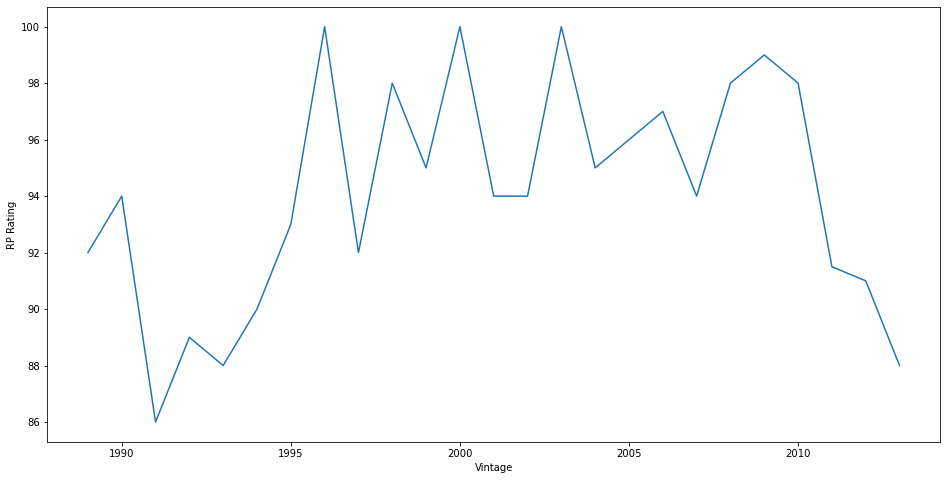

In [131]:
ratings = pd.read_excel('data/ratings.xlsx')
display(ratings)

plt.figure(figsize=(16,8))
sns.lineplot(data=ratings, x='Vintage',y='RP Rating')
sns.lineplot(data=ratings, x='Vintage',y='RP Rating')

plt.show()